In [ ]:


import numpy as np

import tensorflow as tf


In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

from tensorflow.keras import layers, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For working with the dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Utility
import cv2  # If additional image processing is needed
from pathlib import Path  # For easier file path management

In [ ]:
!pip install kaggle


In [ ]:
kaggle_credentails = json.load(open("/content/kaggle.json"))


In [ ]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:32<00:00, 23.9MB/s]
100% 2.04G/2.04G [01:32<00:00, 23.7MB/s]


In [ ]:
!ls


 class_indices.json	 plantvillage-dataset.zip   test_blueberry_healthy.jpg
 kaggle.json		 sample_data		    test_potato_early_blight.jpg
'plantvillage dataset'	 test_apple_black_rot.JPG


In [ ]:
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

[[[167 163 196]
  [166 162 195]
  [165 161 194]
  ...
  [185 182 211]
  [183 180 209]
  [181 178 207]]

 [[170 166 199]
  [169 165 198]
  [168 164 197]
  ...
  [186 183 212]
  [184 181 210]
  [183 180 209]]

 [[170 166 199]
  [169 165 198]
  [168 164 197]
  ...
  [188 185 214]
  [186 183 212]
  [185 182 211]]

 ...

 [[100  90 124]
  [102  92 126]
  [104  94 128]
  ...
  [126 110 137]
  [126 110 137]
  [126 110 137]]

 [[101  91 125]
  [102  92 126]
  [103  93 127]
  ...
  [122 106 133]
  [123 107 134]
  [123 107 134]]

 [[104  94 128]
  [103  93 127]
  [102  92 126]
  ...
  [121 105 132]
  [122 106 133]
  [123 107 134]]]
(256, 256, 3)


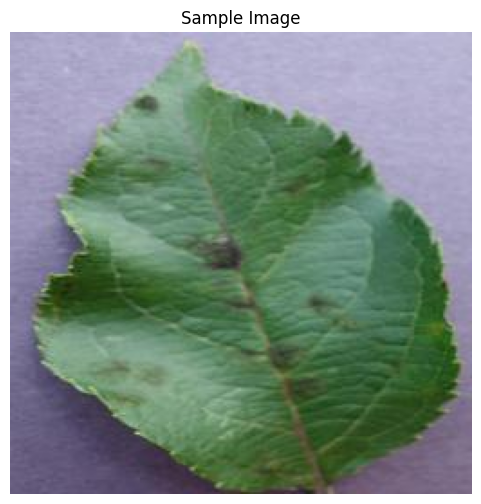

In [ ]:
image = mpimg.imread("/content/plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
print(image)
# Display the image
print(image.shape)
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')  # Remove axis for better visualization
plt.title("Sample Image")
plt.show()

In [ ]:
batch_size=32
img_size = 224

# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)
# Dataset Path
base_dir = '/content/plantvillage dataset/color'

In [ ]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [ ]:


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs with no improvement
    mode='min',               # Minimize validation loss
    restore_best_weights=True # Restore weights from the best epoch
)

# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  ,
    callbacks=[early_stopping]
)

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 117s 84ms/step - accuracy: 0.6163 - loss: 1.4878 - val_accuracy: 0.8513 - val_loss: 0.4733
Epoch 2/8


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.8165
Epoch 3/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 123s 72ms/step - accuracy: 0.9142 - loss: 0.2679 - val_accuracy: 0.8857 - val_loss: 0.4009
Epoch 4/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 5/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 95s 70ms/step - accuracy: 0.9665 - loss: 0.1051 - val_accuracy: 0.8687 - val_loss: 0.5324
Epoch 6/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 3.1574e-04
Epoch 7/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 139s 72ms/step - accuracy: 0.9794 - loss: 0.0658 - val_accuracy: 0.8460 - val_loss: 0.6939
Epoch 8/8
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0172


In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))
# Model Evaluation


340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.8682 - loss: 0.5458
Test loss: 0.53. Test accuracy: 86.87%


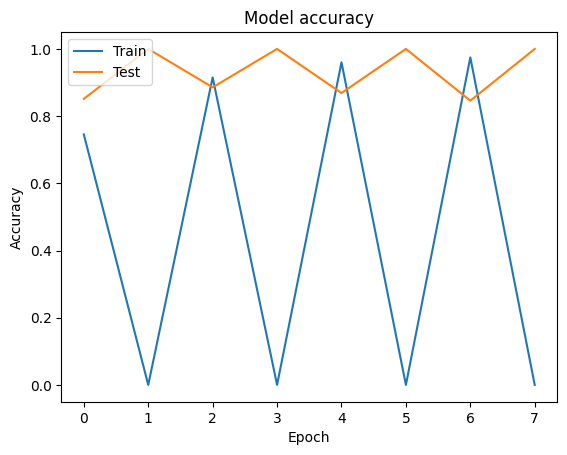

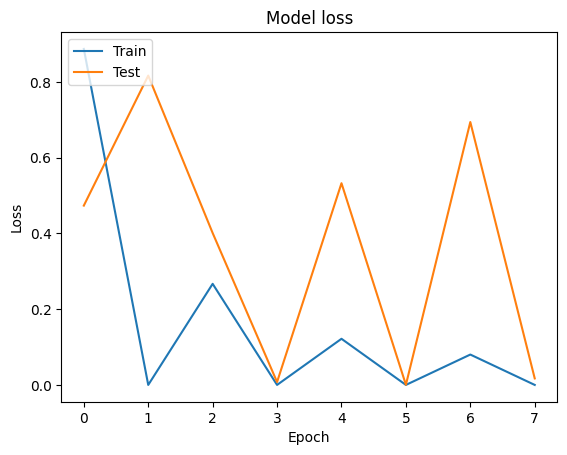

In [ ]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
img = Image.open("/content/image.jpeg")
# Resize the image
img = img.resize((224, 224))
# Convert the image to a numpy array
img_array = np.array(img)
# Add batch dimension
img_array = np.expand_dims(img_array, axis=0)
# Scale the image values to [0, 1]
img_array = img_array.astype('float32') / 255.

In [ ]:
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_indices = {v: k for k, v in train_generator.class_indices.items()}

predicted_class_name = class_indices[predicted_class_index]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:

# Create a mapping from class indices to class names
json.dump(class_indices, open('class_indices.json', 'w'))

In [ ]:

# Output the result
print("Predicted Class Name:", predicted_class_name)

Predicted Class Name: Tomato___Late_blight
